[-0.96918583 -4.96196283] -59.873022714116956 [0.59080705 1.89984644]
[3.12451089 7.98659665] -89.94293447610082 [0.646062   2.13809188]
[ 8.04919661 -1.0299883 ] 75.83698537837273 [1.06441494 1.12310366]
[-6.96210979  2.9814185 ] 55.48697015275069 [0.97754713 1.08829065]
[ 0.92620871 -3.9387123 ] 60.6361306315652 [0.61150764 2.00749744]


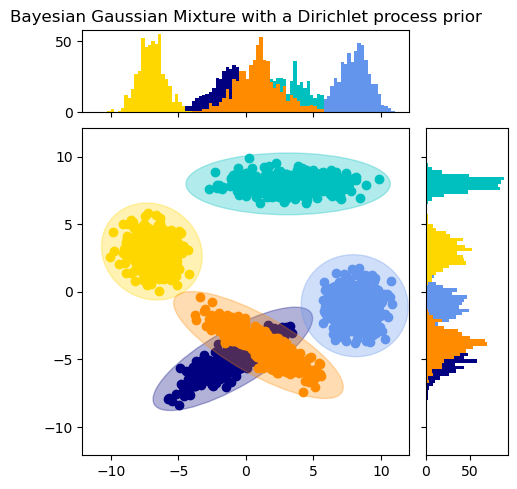

In [85]:
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg

from sklearn import mixture

colors = ["navy", "c", "cornflowerblue", "gold", "darkorange"]
color_iter = itertools.cycle(colors)
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("mycmap", colors)

def scatter_hist(x, y, ax, ax_histx, ax_histy, color):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, color=color)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins, color=color)
    ax_histy.hist(y, bins=bins, color=color, orientation='horizontal')

def plot_results(X, Y_, means, covariances, title):
    # Create a Figure, which doesn't have to be square.
    fig = plt.figure(layout='constrained')
    # Create the main axes, leaving 25% of the figure space at the top and on the
    # right to position marginals.
    ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
    # The main axes' aspect can be fixed.
    ax.set(aspect=1)
    # Create marginal axes, which have 25% of the size of the main axes.  Note that
    # the inset axes are positioned *outside* (on the right and the top) of the
    # main axes, by specifying axes coordinates greater than 1.  Axes coordinates
    # less than 0 would likewise specify positions on the left and the bottom of
    # the main axes.
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
    ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
    
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue

        # Draw the scatter plot and marginals.
        scatter_hist(X[Y_ == i, 0], X[Y_ == i, 1], ax, ax_histx, ax_histy, color=color)
        #ax.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        print(mean, angle, v/(2.0 * np.sqrt(2.0)))
        r = 2.5
        ell = mpl.patches.Ellipse(mean, r*v[0], r*v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.3)
        ax.add_artist(ell)
    plt.title(title)


# Number of samples per component
n_samples = 500

#np.random.seed(0)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([-7, 3])
a = np.pi/6  ## 30°
C_stretch = np.array([[2, 0],[0, 0.5]])
C_rotate = np.array([[np.cos(-a), -np.sin(-a)], [np.sin(-a), np.cos(-a)]])
C = np.dot(C_stretch, C_rotate)
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C_stretch) + np.array([3, 8])
rotated_gaussian = np.dot(np.random.randn(n_samples, 2), C_rotate) + np.array([8, -1])
stretched_rotated_gaussian = np.dot(np.random.randn(n_samples, 2), C) + np.array([-1, -5])
transposed_gaussian = np.dot(np.random.randn(n_samples, 2), np.dot(C_stretch, C_rotate.T)) + np.array([1, -4])
# concatenate the two datasets into the final training set
X = np.vstack([shifted_gaussian, stretched_gaussian, rotated_gaussian, stretched_rotated_gaussian, transposed_gaussian])

# Fit a Dirichlet process Gaussian mixture using five components
dpgmm = mixture.BayesianGaussianMixture(n_components=5, covariance_type="full").fit(X)
plot_results(
    X,
    dpgmm.predict(X),
    dpgmm.means_,
    dpgmm.covariances_,
    "Bayesian Gaussian Mixture with a Dirichlet process prior",
)

plt.show()

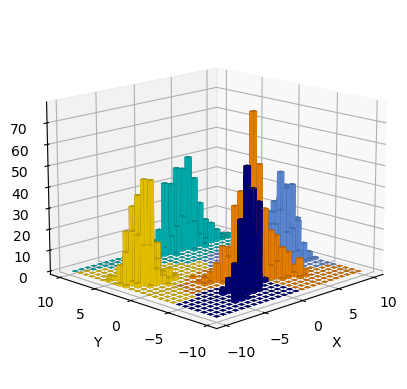

In [96]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x = [x for x,y in X]
y = [y for x,y in X]
hist, xedges, yedges = np.histogram2d(x, y, bins=25, range=[[-10, 10], [-10, 10]])

xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

from matplotlib.colors import Normalize
from matplotlib import cm
#cmap = plt.cm.rainbow
predictions = dpgmm.predict(list(zip(xpos, ypos)))
norm = Normalize(vmin=np.min(predictions), vmax=np.max(predictions))
color = cmap(norm(predictions))

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=color, zsort='average')
ax.view_init(elev=15., azim=-135, roll=0)
ax.set(xlabel='X', ylabel='Y', zlabel='Z')
plt.show()